In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.signal import correlate
from scipy import signal
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
lactic_acid_data = pd.read_csv('lactic_acid_data.csv')
display(lactic_acid_data['lactic_acid (mmol/L)'].describe())

count    2106.000000
mean        2.776401
std         2.454533
min         0.500000
25%         1.400000
50%         2.000000
75%         3.100000
max        20.000000
Name: lactic_acid (mmol/L), dtype: float64

In [3]:
def get_data_for_patient(patient_id):    
    ido2_data = pd.read_csv('ido2_patient_'+str(patient_id)+'.csv')
    ido2_data.columns = ['TS', 'ido2']
    ido2_data.TS = pd.DatetimeIndex(ido2_data.TS)
    ido2_data = ido2_data.sort_values('TS').reset_index()  
    ido2_data.index = ido2_data.TS
    
    ##sorting values in case timestamps are not arranged in correct series order
    
    lactic_acid_info = lactic_acid_data[lactic_acid_data.patient_id == patient_id]
    lactic_acid_info.columns = ['TS', 'patient_id', 'lactic_acid (mmol/L)']
    lactic_acid_info.TS = pd.DatetimeIndex(lactic_acid_info.TS)        
    lactic_acid_info = lactic_acid_info.sort_values('TS').reset_index()
    lactic_acid_info.index = lactic_acid_info.TS

    return ido2_data[['ido2']], lactic_acid_info[['patient_id', 'lactic_acid (mmol/L)']]



In [4]:
o2, acid = get_data_for_patient(17)

File: ido2_patient_1218.csv was an empty file. For the purposes of this assignment I simply neglected the file because there was only one empty file. In the case that there are multiple empty files, that would be treated differently. Example: I could check why the file is not populated and was there no actual data collection for that patient? If so, I would ignore such files while processing all files in a loop.

In [5]:
display(o2['ido2'].describe())
display(acid['lactic_acid (mmol/L)'].describe())

count    24991.000000
mean        45.461006
std         24.897322
min          0.000000
25%         28.000000
50%         50.000000
75%         66.000000
max         97.000000
Name: ido2, dtype: float64

count    19.000000
mean      2.942105
std       1.392965
min       1.500000
25%       1.900000
50%       2.300000
75%       3.950000
max       5.600000
Name: lactic_acid (mmol/L), dtype: float64

In [6]:
acid_minute = acid.resample('30S').mean().interpolate().asfreq('1min', method = 'ffill')['lactic_acid (mmol/L)']
acid_minute.index = acid_minute.index.map(lambda x: x.replace(second=0))


o2_minute = o2.interpolate(axis=0,method = 'ffill').asfreq('1min')['ido2']
o2_minute = o2_minute.transform(lambda x: x.fillna(x.mean()))
o2_minute.index = o2_minute.index.map(lambda x: x.replace(second=0))


merged = pd.merge(acid_minute, o2_minute, left_index=True, right_index=True).asfreq('20min') 

Above I use interpolation to fill in missing values (interpolation joins the immediate previous present value to the next present value by a line).
I first do downsampling to 30 seconds, then interpolating and then upsampling to per minute. I did this step so that the time series data is continous with no missing data points. 
Similarly done for ido2 measurments so that now both measurments can be combined for corresponding timestamps in one dataframe, per patient.\
Problems faced: Interpolate did not seem to accurately fill in NAN values in the ido2 data, thus I filled it in with the mean of that feature. I would have to check in greater details why interpolate did no seem to work as accurately as expected.

As observed in the data-points for a particular patient (eg: patient 4465), lactic acid measurments were seen after intervals of about 20 minutes. In order to avoid any irregularities arising from interpolation/ffill, we scale it back up to 20 minutes sampling.

In [7]:
normalized_df = (merged - merged.min())/(merged.max() - merged.min())

Standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bais.

Steps till now:\
1.Read the acid and o2 data for the specified patient\
2.Change timeindex to DatetimeIndex, sort by timeindex (just to be sure)\
3.Since acid data is read at a lesser frequency, upsample it to 30S (any lower time interval should work), linear interpolate to get rid of NaNs, and downsample it to 1 min\
4.Downsample o2 data to 1 min\
5.Make sure all the second number in time indices are zero\
6.Join both the datasets on timeindex (so that only the overlapping intervals remain)\
7.Normalize the columns between 0 and 1, important since calculating pearsons correlation required the data to be normally distributed with mean 0 and standard deviation of 1.

In [8]:
pearsonr(normalized_df['lactic_acid (mmol/L)'], normalized_df['ido2'])

(-0.5210598963238332, 1.4220639036705825e-08)

The Pearson correlation coefficient measures the linear relationship
 between two variables. It varies between -1 and +1 with 0 implying no
 correlation. Correlations of -1 or +1 imply an exact linear
 relationship. Positive correlations imply that as x increases, so does
 y. Negative correlations imply that as x increases, y decreases.

 The p-value roughly indicates the probability of an uncorrelated system
 producing variables that have a Pearson correlation at least as extreme
 as the one computed from these variables. The p-values are not entirely
 reliable but are probably reasonable for datasets larger than 500 or so.
 
Thus, here we can see that there is a negative correlation between lactic acid and Ido2 measurments (for patient 17), which means that an increase in lactic acid corresponds to a decrease in ido2 or conversely, an increase in ido2 corresponds to a decrease in lactic acid.

When comparing two time series, cross-correlation seeks to obtain a relationship between lags of each series.
It is calculated simply by multiplying and summing two-time series together.

From our cross correlation graphs below we can see that there is no cross correlation between lactic acid and ido2 (for patient 17).

Disadvantages: It is difficult to understand the scoring value. Both metrics must have the same amplitude. If Graph B has the same shape as Graph A but values two times smaller, the correlation will not be detected.
Due to the formula, a zero value will not be taken into account, since 0*i=0.

Thus it is better to use Normalized cross correlation == Pearsons Correlation: 
Normalized cross-correlation scoring is easy to understand:
The higher the value, the higher the correlation is.
The maximum value is 1 when two signals are exactly the same:
The minimum value is -1 when two signals are exactly opposite.
Normalized cross-correlation can detect the correlation of two signals with different amplitudes.


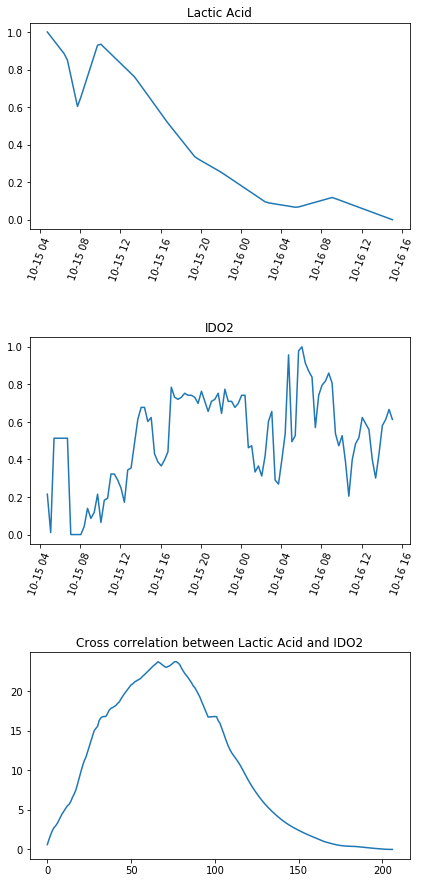

In [9]:
corss_corr = signal.correlate(normalized_df['lactic_acid (mmol/L)'], normalized_df['ido2'])
fig, (a, b, c) = plt.subplots(3, 1)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=3, wspace=None, hspace=None)
a.plot(normalized_df['lactic_acid (mmol/L)'])
a.set_title('Lactic Acid')
b.plot(normalized_df['ido2'])
b.set_title('IDO2')
c.plot(corss_corr)
c.set_title('Cross correlation between Lactic Acid and IDO2')
a.tick_params(axis='x', rotation=70)
b.tick_params(axis='x', rotation=70)

Now, I will do the same steps for all the PID's and average my results to see an average correlation between the two measuments.

In [10]:
filenames = glob.glob("ido2_patient_*.csv")
pid = []
for i in range(len(filenames)):
    pid.append(int(filenames[i].split('.')[0].split('ido2_patient_')[1].strip())) 

In [11]:
def correlations(pid):
    corr_vals = []
    for i in pid:
        o2, acid = get_data_for_patient(i)
        acid_minute = acid.resample('30S').mean().interpolate().asfreq('1min', method = 'ffill')['lactic_acid (mmol/L)']
        acid_minute.index = acid_minute.index.map(lambda x: x.replace(second=0))
        o2_minute = o2.asfreq('1min', method = 'ffill')['ido2']
        o2_minute = o2_minute.transform(lambda x: x.fillna(x.mean()))
        o2_minute.index = o2_minute.index.map(lambda x: x.replace(second=0))
        merged = pd.merge(acid_minute, o2_minute, left_index=True, right_index=True).asfreq('30min') 
        normalized_df = (merged - merged.min())/(merged.max() - merged.min())
        corrs = pearsonr(normalized_df['lactic_acid (mmol/L)'], normalized_df['ido2'])
        corr_vals.append(corrs[0])
    return corr_vals
    
corr_vals = correlations(pid)

In [12]:
mean_correlation = sum(corr_vals)/len(corr_vals)

print('max correlation value:',max(corr_vals))
print('min correlation value:',min(corr_vals))
print('mean correlation value:',mean_correlation)

max correlation value: 0.8768012587307576
min correlation value: -0.6551642218783317
mean correlation value: 0.11262403429752954


Above we can see that some PIDs show a positive correlation and some show a negative. 
From the average correlation value between lactic acid and ido2 measurments, over all patients' data, shows a positive correlation value meaning that an increase in feature 1 causes an increase in feature 2 (features:ido2,lactic acid)
However, seeing both positive and negative values of correlation like in this study is something I have not encountered before. For a more extensive study like this, I would look into why I am recieveing such contradictory answers and try to understand whether any other techniques of processing my data could provide more accuracy when understanding the correlation between the two features.